# Data Loading and Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Load the datasets
true_news = pd.read_csv('True.csv', encoding='utf-8', engine='python')
fake_news = pd.read_csv('Fake.csv', encoding='utf-8', engine='python')

# Label the datasets: 1 for true news, 0 for fake news
true_news['label'] = 1
fake_news['label'] = 0

# Combine the datasets and shuffle
data = pd.concat([true_news, fake_news], axis=0).reset_index(drop=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Define a custom stopword list: start with NLTK's list and add additional words
custom_stopwords = set(stopwords.words('english'))
# Add common words
custom_stopwords.update(['said', 'factbox', 'the', 'it', 'we', 'he', 'that'])

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize using regex to capture words (this avoids issues with concatenated tokens)
    words = re.findall(r'\w+', text)
    # Remove stopwords and lemmatize each word
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in custom_stopwords]
    return ' '.join(cleaned_words)

# Combine title and text into a single field and clean it
data['content'] = data['title'] + ' ' + data['text']
data['cleaned_content'] = data['content'].apply(clean_text)

# Create the TF-IDF features with additional stopword removal in the vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# EDA and Class imbalance check


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            44898 non-null  object
 1   text             44898 non-null  object
 2   subject          44898 non-null  object
 3   date             44898 non-null  object
 4   label            44898 non-null  int64 
 5   content          44898 non-null  object
 6   cleaned_content  44898 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.4+ MB
None

Missing Values:
title              0
text               0
subject            0
date               0
label              0
content            0
cleaned_content    0
dtype: int64

Class Distribution:
label
0    23481
1    21417
Name: count, dtype: int64


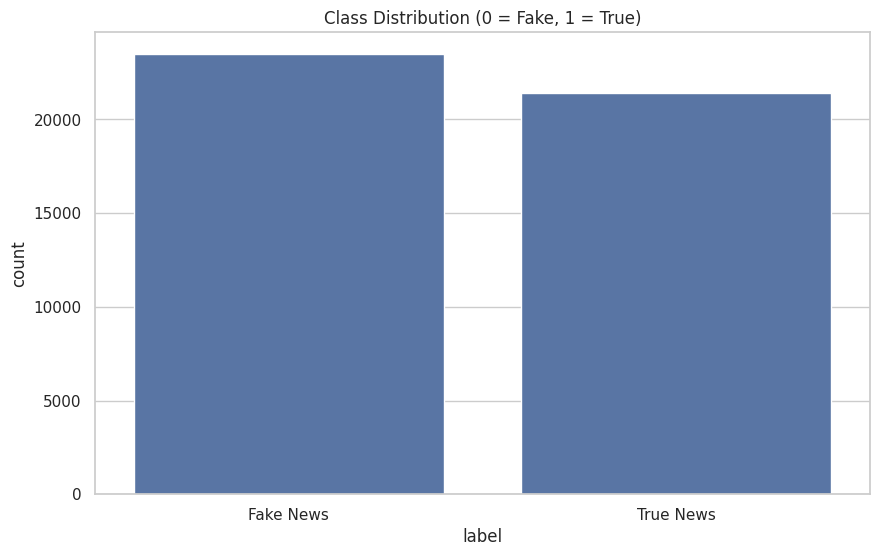


Fake News: 23481 (52.30%)
True News: 21417 (47.70%)


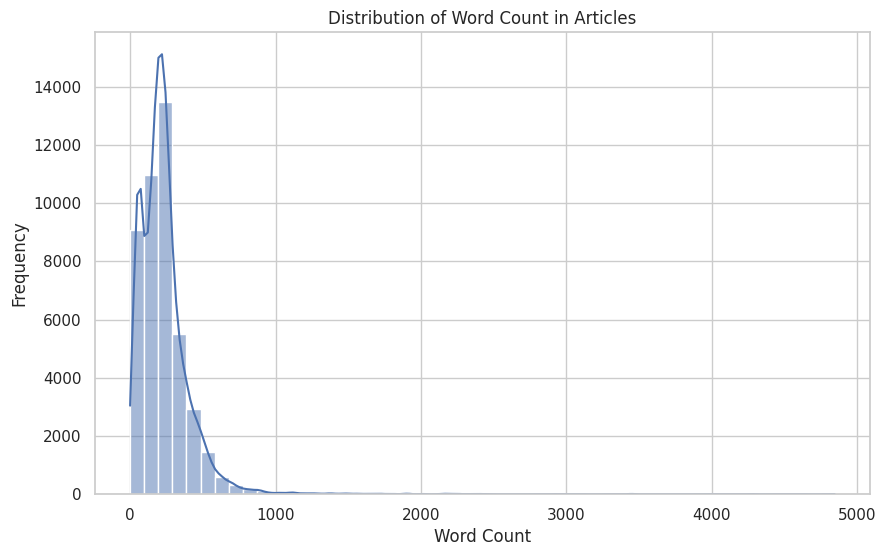

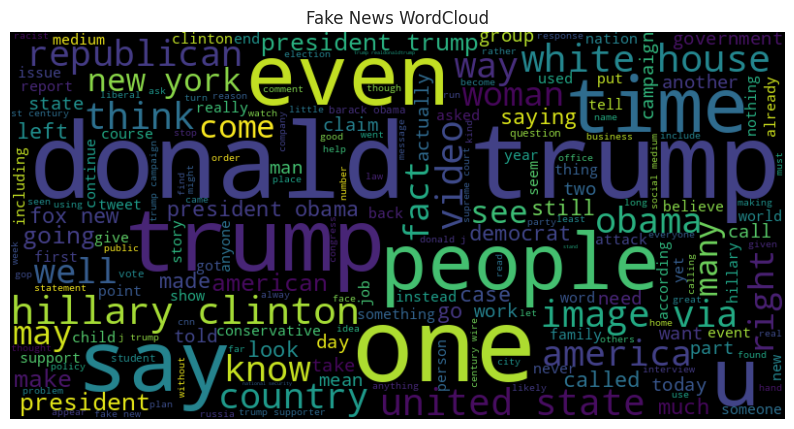

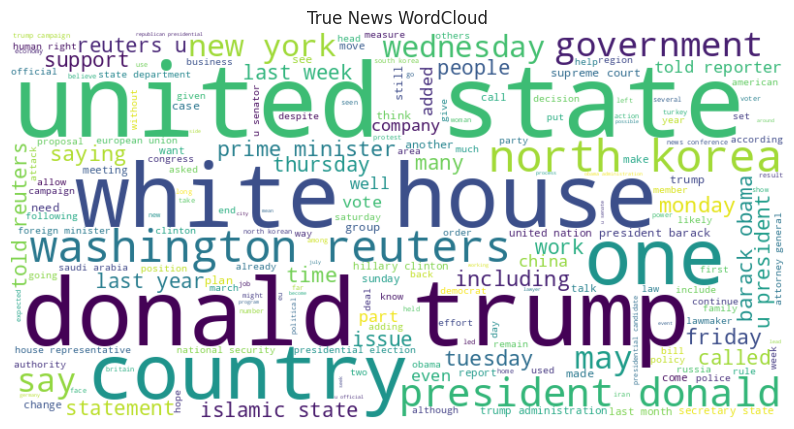

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set plot styles
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# 1. Basic info
print("Dataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())
print("\nClass Distribution:")
print(data['label'].value_counts())

# 2. Visualize class distribution
sns.countplot(x='label', data=data)
plt.title('Class Distribution (0 = Fake, 1 = True)')
plt.xticks([0, 1], ['Fake News', 'True News'])
plt.show()

# 3. Check for class imbalance
fake_count = data['label'].value_counts()[0]
true_count = data['label'].value_counts()[1]
total = fake_count + true_count
print(f"\nFake News: {fake_count} ({fake_count/total:.2%})")
print(f"True News: {true_count} ({true_count/total:.2%})")

# 4. Word count distribution
data['word_count'] = data['cleaned_content'].apply(lambda x: len(x.split()))
sns.histplot(data['word_count'], bins=50, kde=True)
plt.title('Distribution of Word Count in Articles')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# 5. WordClouds for Fake and True News
fake_text = ' '.join(data[data['label'] == 0]['cleaned_content'].tolist())
true_text = ' '.join(data[data['label'] == 1]['cleaned_content'].tolist())

# WordCloud for Fake News
wordcloud_fake = WordCloud(width=800, height=400, background_color='black').generate(fake_text)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News WordCloud')
plt.show()

# WordCloud for True News
wordcloud_true = WordCloud(width=800, height=400, background_color='white').generate(true_text)
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis('off')
plt.title('True News WordCloud')
plt.show()

## TF-IDF and Baseline Model Training

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'C': 100, 'solver': 'liblinear'}
Best cross-validation accuracy: 0.993067579911366
Test Accuracy: 0.9935412026726058
Test Precision: 0.9930442847206121
Test Recall: 0.9935049872419393
Test F1 Score: 0.9932745825602969


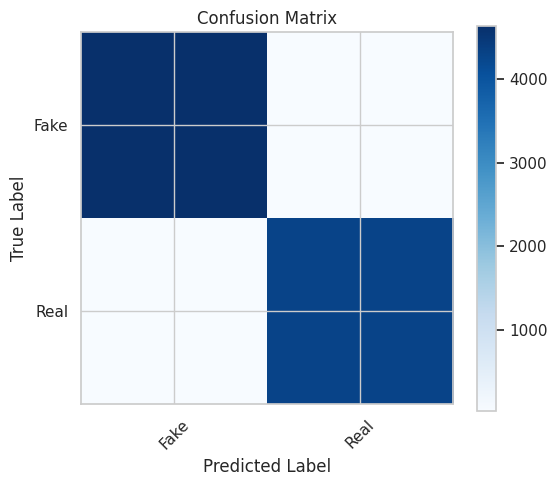

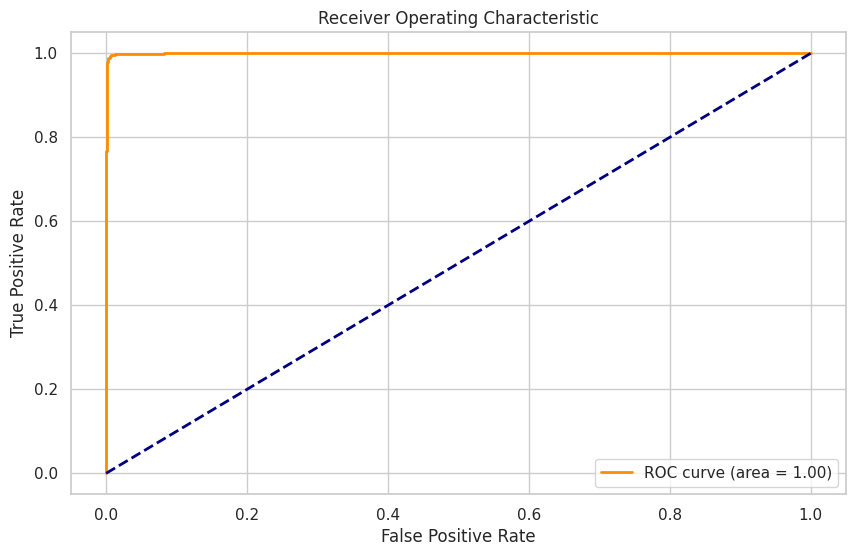

In [ ]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(data[['cleaned_content', 'label']], test_size=0.2, random_state=42)

# Feature extraction using TF-IDF (on cleaned text)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train = tfidf_vectorizer.fit_transform(train_df['cleaned_content'])
X_test = tfidf_vectorizer.transform(test_df['cleaned_content'])
y_train = train_df['label'].values
y_test = test_df['label'].values

# Baseline Model: Logistic Regression with Hyperparameter Tuning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

logreg = LogisticRegression(random_state=42, max_iter=1000)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Test Accuracy:", acc)
print("Test Precision:", prec)
print("Test Recall:", rec)
print("Test F1 Score:", f1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Fake', 'Real'], rotation=45)
plt.yticks(tick_marks, ['Fake', 'Real'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Save the best model to disk
import pickle
with open('best_logreg_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Advanced Model Training - Bert

In [ ]:
# Advanced Model Development: BERT Fine-Tuning

!pip install transformers datasets evaluate
import torch
from transformers import BertTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import evaluate
import os

# Disable W&B (Weights & Biases) logging for this run
os.environ['WANDB_MODE'] = 'disabled'

# Prepare train and test data for Hugging Face Datasets
train_df = train_df.rename(columns={'cleaned_content': 'text'})
test_df = test_df.rename(columns={'cleaned_content': 'text'})
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenization function for dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

# Tokenize the dataset
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Convert datasets to PyTorch tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Define evaluation metrics
metric_accuracy = evaluate.load('accuracy')
metric_precision = evaluate.load('precision')
metric_recall = evaluate.load('recall')
metric_f1 = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric_accuracy.compute(predictions=predictions, references=labels)
    precision = metric_precision.compute(predictions=predictions, references=labels, average='weighted')
    recall = metric_recall.compute(predictions=predictions, references=labels, average='weighted')
    f1 = metric_f1.compute(predictions=predictions, references=labels, average='weighted')
    return {
        'accuracy': accuracy['accuracy'],
        'precision': precision['precision'],
        'recall': recall['recall'],
        'f1': f1['f1']
    }

# Set up training arguments
training_args = TrainingArguments(
    output_dir='results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[],  # disable default logging to W&B
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='logs',
    logging_steps=10,
    metric_for_best_model='accuracy',
    bf16=True
)




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/35918 [00:00<?, ? examples/s]

Map:   0%|          | 0/8980 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
# Train the model
trainer.train()

# Evaluate the model on the test set
results = trainer.evaluate()
print("Evaluation results:", results)

# Save the fine-tuned model and tokenizer
model.save_pretrained('fine_tuned_bert')
tokenizer.save_pretrained('fine_tuned_bert')


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000100,0.011270,0.997884,0.997889,0.997884,0.997884
2,0.000000,0.005655,0.999220,0.999221,0.999220,0.999220


Evaluation results: {'eval_loss': 0.005654843989759684, 'eval_accuracy': 0.9992204899777283, 'eval_precision': 0.9992206924118906, 'eval_recall': 0.9992204899777283, 'eval_f1': 0.9992204794919683, 'eval_runtime': 7.9239, 'eval_samples_per_second': 1133.279, 'eval_steps_per_second': 70.925, 'epoch': 2.0}


('fine_tuned_bert/tokenizer_config.json',
 'fine_tuned_bert/special_tokens_map.json',
 'fine_tuned_bert/vocab.txt',
 'fine_tuned_bert/added_tokens.json')

# Analyze logistic regression coefficients

Top 20 features indicative of True News (positive coefficients):
rival: 8.7049
referring: 8.8149
paragraph: 8.8841
edt: 8.9741
graphic: 8.9977
comment: 9.1323
est: 9.2136
saying: 9.7123
showed: 9.8760
monday: 10.2136
statement: 10.4815
spokesman: 11.1999
km: 11.4518
thursday: 13.3740
tuesday: 13.7142
friday: 14.0012
washington: 15.4741
wednesday: 16.1651
nov: 17.0957
reuters: 118.2926

Top 20 features indicative of Fake News (negative coefficients):
via: -38.6469
image: -32.0448
breaking: -25.3415
video: -22.3763
gop: -22.2877
wire: -18.0523
hillary: -15.9055
entire: -14.7795
read: -13.4567
reportedly: -13.3147
sen: -13.2408
ap: -13.2040
rep: -13.0163
watch: -12.6674
daily: -12.2689
gov: -12.1501
breitbart: -11.9579
even: -11.6568
saidthe: -11.4246
mail: -10.6269


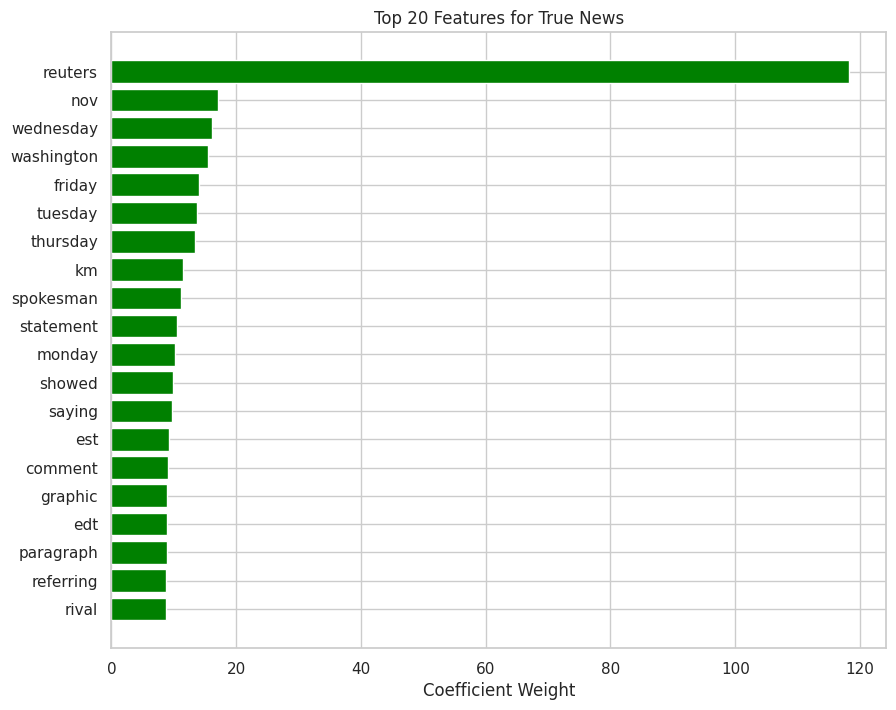

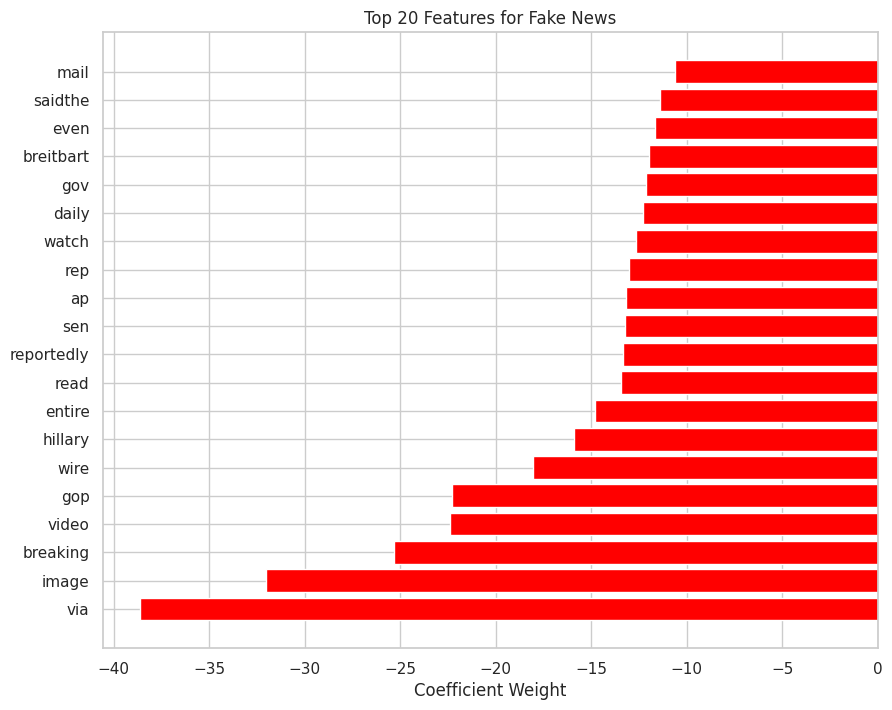

In [ ]:
# Analyze logistic regression coefficients

# Get the feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()
# Extract the coefficients (weights) from the best logistic regression model
coefficients = best_model.coef_[0]

# Get the indices for the top 20 features for each class
top20_pos_indices = np.argsort(coefficients)[-20:]
top20_neg_indices = np.argsort(coefficients)[:20]

# Retrieve feature names and corresponding weights
top20_pos_features = feature_names[top20_pos_indices]
top20_pos_weights = coefficients[top20_pos_indices]
top20_neg_features = feature_names[top20_neg_indices]
top20_neg_weights = coefficients[top20_neg_indices]

# Display top features indicative of True News
print("Top 20 features indicative of True News (positive coefficients):")
for feature, weight in zip(top20_pos_features, top20_pos_weights):
    print(f"{feature}: {weight:.4f}")

# Display top features indicative of Fake News
print("\nTop 20 features indicative of Fake News (negative coefficients):")
for feature, weight in zip(top20_neg_features, top20_neg_weights):
    print(f"{feature}: {weight:.4f}")

import matplotlib.pyplot as plt

# Plot for True News features
plt.figure(figsize=(10, 8))
plt.barh(top20_pos_features, top20_pos_weights, color='green')
plt.title("Top 20 Features for True News")
plt.xlabel("Coefficient Weight")
plt.show()

# Plot for Fake News features
plt.figure(figsize=(10, 8))
plt.barh(top20_neg_features, top20_neg_weights, color='red')
plt.title("Top 20 Features for Fake News")
plt.xlabel("Coefficient Weight")
plt.show()
